# Predict the future sales of Russian retail stores

### by Anna

In [43]:
import os
import glob

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

from itertools import product


#plot
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns



#import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn import ensemble, metrics
from sklearn import linear_model, preprocessing
from sklearn.model_selection import GroupKFold
import lightgbm as lgb

# datetime
from datetime import datetime, timedelta,date


from collections import Counter
from operator import itemgetter

from googletrans import Translator
translator = Translator()

## 1. Import data

Use function to retrevie the data in one directory and store them in dictonary to better control the datasets.

In [52]:
path = 'C:/Users/chang/Documents/EY/Dataset/Dataset/'

def path_leaf(path):
    return path.strip('/').strip('\\').split('/')[-1].split('\\')[-1]

allFiles = glob.glob(os.path.join(path, "*.csv"))
dict_data = {}#use dictionary here to store the multiple dataframes

for file_ in allFiles:
    df_name = path_leaf(file_).replace(".csv", "")
    df = pd.read_csv(file_, index_col=None, header=0)
    df.name = df_name
    dict_data[df_name] = df

In [4]:
print("All Accessible Datasets: ")
for k in dict_data.keys():
    print (" ",k)

All Accessible Datasets: 
  items
  item_categories
  sales_train
  shops
  test


## 2. Prepocess and Understand the Datasets

### 2.1 Clean data

In [5]:
train = dict_data['sales_train'].copy()
items = dict_data['items'].copy()
categories = dict_data['item_categories'].copy()
shops =  dict_data['shops'].copy()
test =  dict_data['test'].copy()


print("------------------Train dataset information ----------------------------")
train.info()


#downcaste the DataFrame to save memory
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

train = downcast_dtypes(train)


print("")
print("--------------Train dataset information after downcasting--------------")
print(train.info())

------------------Train dataset information ----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB

--------------Train dataset information after downcasting--------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int16
shop_id           int16
item_id           int16
item_price        float32
item_cnt_day      float32
dtypes: float32(2), int16(3), object(1)
memory usage: 61.6+ MB
None


In [6]:
print("----------Missing value-----------")
print(train.isnull().sum())
print("----------Null value--------------")
print(train.isna().sum())
print("-------------Other----------------")
print("shape of data:", train.shape)
print('Number of duplicates:', len(train[train.duplicated()]))

----------Missing value-----------
date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64
----------Null value--------------
date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64
-------------Other----------------
shape of data: (2935849, 6)
Number of duplicates: 6


We have no missing or null values, however, we need to deal with the duplicates here

##### Duplicates

In [7]:
# drop duplicates
subset = ['date','date_block_num','shop_id','item_id','item_cnt_day']
print(train.duplicated(subset=subset).value_counts())
train.drop_duplicates(subset=subset, inplace=True)

False    2935825
True          24
dtype: int64


##### Outlinears

In [8]:
print("Total Month number:", train['date_block_num'].max()+1)
print("------------Daily Sales Description----------")
print(train['item_cnt_day'].describe())
print("------------Item Price Description----------")
print(train['item_price'].describe())

Total Month number: 34
------------Daily Sales Description----------
count    2.935825e+06
mean     1.242643e+00
std      2.612224e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64
------------Item Price Description----------
count    2.935825e+06
mean     8.906257e+02
std      1.726446e+03
min     -1.000000e+00
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
max      3.079800e+05
Name: item_price, dtype: float64


#### After the initial check of dataset, we need to take a look into the data in detail in order to decide the best way to safely handle all the outliners, missing values, abnormal values.

1.Obviously we will have outliner and abnoarmal values here.Daily Sales maximum is 2169, but the mean value is 1.24. The maximum price is 307980, and price have minimum value of -1, which is highly likely an error here. 

2.We check with each value we want to delete or fill with, safely draw the conclusion how should we handle them.

Sale volume outliers: [ 8057 20949  9242 19437  3731 11373  9249  9248]
Item price outliers: [11365  6066 13199]


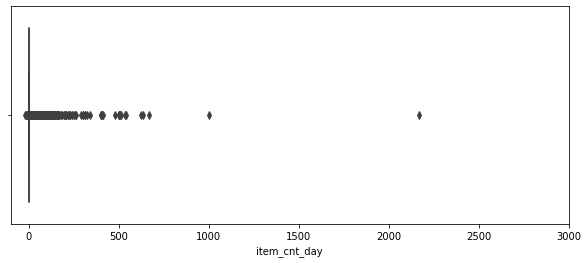

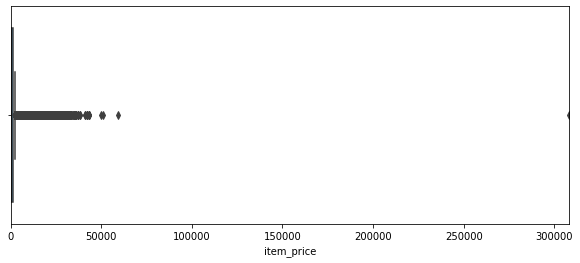

In [9]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train['item_cnt_day'])
print('Sale volume outliers:',train['item_id'][train['item_cnt_day']>500].unique())


plt.figure(figsize=(10,4))
plt.xlim(train['item_price'].min(), train['item_price'].max())
sns.boxplot(x=train['item_price'])
print('Item price outliers:',train['item_id'][train['item_price']>50000].unique())

Let's check for the outliners and abnormal values and decide how to deal with them

In [10]:
train[train['item_cnt_day'] == 2169]
items[items['item_id'] == 11373]

,item_name,item_id,item_category_id
11373,Доставка до пункта выдачи (Boxberry),11373,9


This item is related to point of delivery and the Russian shipment company 'Boxberry' by translation. Let's look at some of the other daiy sales for this item.

We can see that item 11373 usually has sells much less. We should get rid of it.

In [11]:
#train['item_cnt_day'].sort_values(ascending=False)
train['item_price'].sort_values(ascending=False)[:5]

1163158    307980.0
885138      59200.0
1488135     50999.0
2327159     49782.0
2931380     42990.0
Name: item_price, dtype: float32

In [12]:
train[train['item_price'] == 307980]
items[items['item_id'] == 6066]

,item_name,item_id,item_category_id
6066,Radmin 3 - 522 лиц.,6066,75


Once again, using Google translate, I found that this is an antivirus sold to 522 people and the price is probabaly the cost of one installation times 522. Let's see if there are other transactions related to this software in our training set.

In [13]:
items[items['item_id'] == 11365]
train[train['item_id'] == 11365].sort_values(['item_price']).tail()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
885161,28.09.2013,8,12,11365,9370.0,1.0
302568,12.03.2013,2,12,11365,10540.0,1.0
885165,23.09.2013,8,12,11365,11880.0,1.0
302544,05.03.2013,2,12,11365,14530.0,1.0
885138,17.09.2013,8,12,11365,59200.0,1.0


In [14]:
items[items['item_id'] == 13199]
train[train['item_id'] == 13199]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1488135,20.03.2014,14,25,13199,50999.0,1.0


Now, we can safely conclude that we want to delete some outlinears. 

Also, we want to fill the abnormal values with the right value - meadian value of that shop in that month

In [15]:
#deal with the outlinears
train = train[train['item_cnt_day'] < 500]
train = train[train['item_price'] < 50000]

In [16]:
##correct the price with -1 with the median value
price_correction = train[(train['shop_id'] == 32) & (train['item_id'] == 2973) & 
                         (train['date_block_num'] == 4) & (train['item_price'] > 0)].item_price.median()
train.loc[train['item_price'] < 0, 'item_price'] = price_correction

### Test/ train comparasion

##### Let's take a look at outdated items

In [17]:
print("items in test:",len(list(set(test.item_id))))
print("pairs of item*shop in test:",len(test))
print("new items in test(in test but not in train):",len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))))  

items in test: 5100
pairs of item*shop in test: 214200
new items in test(in test but not in train): 363


In [18]:
good_sales = test.merge(train, on=['item_id','shop_id'], how='left').dropna()
good_pairs = test[test['ID'].isin(good_sales['ID'])]
no_data_items = test[~(test['item_id'].isin(train['item_id']))]

print('Number of perfect pairs(Item/shop pairs that are in train):', len(good_pairs))
print('Items without any data:', len(no_data_items))
print('Only Item_id Info(Items that are in train):', len(test)-len(no_data_items)-len(good_pairs))

Number of perfect pairs(Item/shop pairs that are in train): 111403
Items without any data: 15246
Only Item_id Info(Items that are in train): 87551


##### Deal with the matches

Test set is products of some shops and some items within 34 month. There are 5100 items * 42 shops = 214200 pairs. 

363 items are new compared to the train. Hence, for the most of the items in the test set target value should be zero. 

In the other hand train set contains only pairs which were sold or returned in the past. Tha main idea is to calculate monthly sales and extend it with zero sales for each unique pair within the month. This way train data will be similar to test data.

In [19]:
# drop shops&items not in test data
test_shops = test.shop_id.unique()
test_items = test.item_id.unique()
train = train[train.shop_id.isin(test_shops)]
train = train[train.item_id.isin(test_items)]

In [20]:
from itertools import product

# create all combinations
block_shop_combi = pd.DataFrame(list(product(np.arange(34), test_shops)), columns=['date_block_num','shop_id'])
shop_item_combi = pd.DataFrame(list(product(test_shops, test_items)), columns=['shop_id','item_id'])
all_combi = pd.merge(block_shop_combi, shop_item_combi, on=['shop_id'], how='inner')
print(len(all_combi), 34 * len(test_shops) * len(test_items))

# group by monthly
train_base = pd.merge(all_combi, train, on=['date_block_num','shop_id','item_id'], how='left')
train_base['item_cnt_day'].fillna(0, inplace=True)
train_grp = train_base.groupby(['date_block_num','shop_id','item_id'])

7282800 7282800


In [21]:
# summary count by month
train_monthly = pd.DataFrame(train_grp.agg({'item_cnt_day':['sum','count']})).reset_index()
train_monthly.columns = ['date_block_num','shop_id','item_id','item_cnt','item_order']
print(train_monthly[['item_cnt','item_order']].describe())

# trim count
train_monthly['item_cnt'].clip(0, 20, inplace=True)

#train_monthly.head()

           item_cnt    item_order
count  7.282800e+06  7.282800e+06
mean   2.213334e-01  1.085718e+00
std    3.140399e+00  7.254392e-01
min   -4.000000e+00  1.000000e+00
25%    0.000000e+00  1.000000e+00
50%    0.000000e+00  1.000000e+00
75%    0.000000e+00  1.000000e+00
max    1.305000e+03  3.100000e+01


# 3.Feature Engineering and EDA


# 3.1 items

### Items EDA

### key findings

#### Popular Version of product
we can find that the most popular products tend to be Russian Domestic version

Russian Version:"sрусская версия". 

Russian subtitles:"русские субтитры"

This shows that Russian domestic electronic products are more popular than other versions.

In [23]:
items['name_1'], items['name_2'] = items['item_name'].str.split('[', 1).str
items['name_1'], items['name_3'] = items['item_name'].str.split('(', 1).str

items['name_2'] = items['name_2'].str.replace('[^A-Za-z0-9А-Яа-я]+', ' ').str.lower()
items['name_3'] = items['name_3'].str.replace('[^A-Za-z0-9А-Яа-я]+', ' ').str.lower()
items = items.fillna('0')

#### Item names feature exploration

we can rule out some meaningless words and lots of them are related to Electronic products

In [27]:
from collections import Counter
from operator import itemgetter

In [28]:
items['name_1'], items['name_2'] = items['item_name'].str.split('[', 1).str
items['name_1'], items['name_3'] = items['item_name'].str.split('(', 1).str

items['name_2'] = items['name_2'].str.replace('[^A-Za-z0-9А-Яа-я]+', ' ').str.lower()
items['name_3'] = items['name_3'].str.replace('[^A-Za-z0-9А-Яа-я]+', ' ').str.lower()
items = items.fillna('0')

result_1 = Counter(' '.join(items['name_2'].values.tolist()).split(' ')).items()
result_1 = sorted(result_1, key=itemgetter(1))
result_1 = pd.DataFrame(result_1, columns=['feature', 'count'])
result_1 = result_1[(result_1['feature'].str.len() > 1) & (result_1['count'] > 200)]

result_2 = Counter(' '.join(items['name_3'].values.tolist()).split(" ")).items()
result_2 = sorted(result_2, key=itemgetter(1))
result_2 = pd.DataFrame(result_2, columns=['feature', 'count'])
result_2 = result_2[(result_2['feature'].str.len() > 1) & (result_2['count'] > 200)]

result = pd.concat([result_1, result_2])
result = result.drop_duplicates(subset=['feature'])

##tranlate to russian
##result['feature'] = result['feature'].apply(lambda x: translator.translate(x).text)

print('Most common aditional features:')
result

Most common aditional features:


,feature,count
130,документация,284
131,английская,340
132,русские,399
133,субтитры,400
134,360,465
135,jewel,552
136,xbox,589
137,ps3,611
138,русская,1428
139,цифровая,1995


#### Item name correction
For our basic "name feature" it is enough to find identical items (not similar but identical)

I try to translate them to deep dig into the name features, but due to the Google API limitation, I cannot use it for too many times. This can be done in next step.

In [30]:
##tranlate from russian to english

# from googletrans import Translator
# translator = Translator()
# result['feature'] = result['feature'].apply(lambda x: translator.translate(x).text)

In [31]:
print('Unique item names:', len(items['item_name'].unique()))
import re
def name_correction(x):
    x = x.lower()
    x = x.partition('[')[0]
    x = x.partition('(')[0]
    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x)
    x = x.replace('  ', ' ')
    x = x.strip()
    return x

## translate 
#items['item_name'] = items['item_name'].apply(lambda x: name_correction(x))
#items.head()

##encode names
items['name_2_code'] = LabelEncoder().fit_transform(items['name_2'])
items['name_3_code'] = LabelEncoder().fit_transform(items['name_3'])

Unique item names: 22170


In [32]:
print('Unique item names after correction:', len(items['item_name'].unique()))

items.drop(['item_name'], axis=1, inplace=True)

Unique item names after correction: 22170


In [34]:
item_group =pd.merge(train_monthly,items,on=['item_id'],how = 'left')

In [35]:
item_group = item_group[['item_cnt','name_2']].groupby(['name_2']).sum().reset_index().sort_values(by='item_cnt',ascending=False)
item_group[item_group["name_2"]!='0'][:10]            

,name_2,item_cnt
30,pc русская версия,85503.0
25,pc jewel русская версия,68940.0
45,ps3 русская версия,66226.0
53,ps4 русская версия,49368.0
27,pc jewel русские субтитры,35761.0
67,xbox 360 русская версия,32017.0
55,ps4 русские субтитры,18501.0
51,ps3 русские субтитры,18155.0
73,xbox 360 русские субтитры,14247.0
37,pc цифровая версия,13070.0


# 3.2 Shops
The structure of the shop information is: Shop City | Shop type | Shop name. 

After extract the shop city and shop type. I research for the shopping centers, they can be divided into two main types:

1.Shopping Centers

2.Shopping centers with entertainment facilities(like skating,movies..)


###  Key Findings:
#### 1.Large Scale cities in terms of sasle
sum of the sales

1.Moscow	397349.0

2.SPb	63965.0

3.ufa	55922.0

4.Tyumen	45288.0

5.Samara	40798.0

we should target these cities cause the market share is large here and try to find out prediction of next month

####  2.Check low volume citys

Novosibirsk(новосибирск) has a total sales of 324.0 during the whole time.

This sale volume it is extremely low, and the mall type is a shopping mall with entertainment center, which means it should be large scale shopping center and the rent could be really high here.

We need to consider checking the running cost of it, either exit the market or find a way to promote the sales

In [36]:
shops = dict_data['shops']
shops['shop_name'] = shops['shop_name'].apply(lambda x: x.lower()).str.replace('[^\w\s]', '').str.replace('\d+','').str.strip()
shops['shop_city'] = shops['shop_name'].str.partition(' ')[0]
shops['shop_type'] = shops['shop_name'].apply(lambda x: 'мтрц' if 'мтрц' in x else 'трц' if 'трц' in x else 'трк' if 'трк' in x else 'тц' if 'тц' in x else 'тк' if 'тк' in x else 'Nah')
shops['city_code'] = LabelEncoder().fit_transform(shops['shop_city'])
shops['shop_type_code'] = LabelEncoder().fit_transform(shops['shop_type'])


In [37]:
# from googletrans import Translator
# translator = Translator()
# shops['shop_city'] = shops['shop_city'].apply(lambda x: translator.translate(x).text)


Take a close look we can find out that some shops have duplicated id/name, we need to deal with these values.

The best way here is to converted train shop_id to correct shop_id that is in the test set

11 => 10

1 => 58

0 => 57

40 => 39



In [38]:
test['shop_id'].unique()

array([ 5,  4,  6,  3,  2,  7, 10, 12, 28, 31, 26, 25, 22, 24, 21, 15, 16,
       18, 14, 19, 42, 50, 49, 53, 52, 47, 48, 57, 58, 59, 55, 56, 36, 37,
       35, 38, 34, 46, 41, 44, 39, 45], dtype=int64)

In [39]:
# Якутск Орджоникидзе
train.loc[train.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 11, 'shop_id'] = 10
train.loc[train.shop_id == 40, 'shop_id'] = 39

### Shops EDA

In [40]:
shop_group =pd.merge(train_monthly,shops,on=['shop_id'],how = 'left')
shop_group_city = shop_group[['item_cnt','shop_city','shop_type']].groupby(['shop_city','shop_type']).sum().reset_index().sort_values(by='item_cnt',ascending=False)
shop_group_city = shop_group_city[shop_group_city['shop_type'] != 'Nah']
shop_group_city['mall_type'] = np.where((shop_group_city['shop_type']=='тц') | (shop_group_city['shop_type']=='тк'), 'shopping center', 'shopping and entertaiment')

In [41]:
shop_group_city.groupby(['shop_city','mall_type']).sum().sort_values(by='item_cnt').head()

,,item_cnt
shop_city,mall_type,
новосибирск,shopping and entertaiment,324.0
ростовнадону,shopping and entertaiment,10799.0
тюмень,shopping and entertaiment,12259.0
балашиха,shopping and entertaiment,15935.0
адыгея,shopping center,17393.0


In [44]:
mostsales_city = shop_group_city.groupby(['shop_city']).sum().reset_index().sort_values(by='item_cnt',ascending=False)[:5]
mostsales_city["shop_city"] = mostsales_city["shop_city"].apply(lambda x: translator.translate(x).text)
mostsales_city

,shop_city,item_cnt
10,Moscow,397349.0
17,SPb,63965.0
21,ufa,55922.0
20,Tyumen,45288.0
15,Samara,40798.0


# 3.3 Categories

##### We group the data by city and category type（both are extrated by text mining from the original dateset)

####  1. A lot of 0 in PC and Delivery

1).PC(no PC sales at all,no matter which city the store is in)

2).Delivery(only delivery expense here is "internetmagazin")

We can find out that our delivery method include internet and magazine, we can explore more distant sales distribution channels


#### 2.Look at the categories sold at different shops

1).For distribution channel on digital, they only categories are sold on digital distrubition channels : Games,books,and programs.

2).For every shops including digital and online magazine, the best sales product is games


In [45]:
categories = dict_data['item_categories'].copy()
cat_type = categories['item_category_name'].apply(lambda x: str(x).split(' ')[0])
categories['cat_type_name'] = cat_type
categories['cat_type'] = pd.Categorical(cat_type).codes

In [46]:
cat_with_item = pd.merge(items, categories.loc[:,['item_category_id','cat_type','cat_type_name']], on=['item_category_id'], how='left')
city_dict = shops[["shop_id","shop_city"]]
city_dict["shop_city"] = city_dict["shop_city"].apply(lambda x: translator.translate(x).text)
city_dict = dict(sorted(city_dict.values.tolist()))
groupcate = pd.merge(train_monthly, cat_with_item, on=['item_id'], how='left')
groupcate['city'] = groupcate ['shop_id'].map(city_dict)
groupcate = groupcate[["cat_type_name","city","item_cnt",]].groupby(["city","cat_type_name",]).sum().reset_index().sort_values(["city","item_cnt"])
groupcate['cat_type_name'] = groupcate['cat_type_name'].apply(lambda x: translator.translate(x).text)



In [47]:
groupcate.head()

,city,cat_type_name,item_cnt
0,Adygea,PC,0.0
2,Adygea,Delivery,0.0
12,Adygea,elements,48.0
3,Adygea,Game,187.0
11,Adygea,System Tools,197.0


In [49]:
groupcate[groupcate['cat_type_name']=="Delivery"].sort_values(by='item_cnt',ascending=False).head(1)

,city,cat_type_name,item_cnt
301,internetmagazin,Delivery,3319.0


In [ ]:
## code to look the dataset in detail
# with pd.option_context("display.max_rows", 400):
#     display(groupcate)

Merge dataset for training with mean features

In [53]:
categories = dict_data['item_categories'].copy()
cat_type = categories['item_category_name'].apply(lambda x: str(x).split(' ')[0])
categories['cat_type'] = pd.Categorical(cat_type).codes
##merge items and categories
items = pd.merge(items, categories.loc[:,['item_category_id','cat_type']], on=['item_category_id'], how='left')
# By shop,item
grp = train_monthly.groupby(['shop_id', 'item_id'])
train_shop = grp.agg({'item_cnt':['mean','median','std'],'item_order':'mean'}).reset_index()
train_shop.columns = ['shop_id','item_id','cnt_mean_shop','cnt_med_shop','cnt_std_shop','order_mean_shop']

#print(train_shop[['cnt_mean_shop','cnt_med_shop','cnt_std_shop']].describe())
#train_shop.head()


In [54]:
# By shop,item
grp = train_monthly.groupby(['shop_id', 'item_id'])
train_shop = grp.agg({'item_cnt':['mean','median','std'],'item_order':'mean'}).reset_index()
train_shop.columns = ['shop_id','item_id','cnt_mean_shop','cnt_med_shop','cnt_std_shop','order_mean_shop']

#print(train_shop[['cnt_mean_shop','cnt_med_shop','cnt_std_shop']].describe())
#train_shop.head()

In [55]:
# By shop,item_group
train_cat_monthly = pd.merge(train_monthly, items, on=['item_id'], how='left')
grp = train_cat_monthly.groupby(['shop_id', 'cat_type'])
train_shop_cat = grp.agg({'item_cnt':['mean']}).reset_index()
train_shop_cat.columns = ['shop_id','cat_type','cnt_mean_shop_cat']

#print(train_shop_cat.loc[:,['cnt_mean_shop_cat']].describe())
#train_shop_cat.head()

# 3.4 Dates

#### 1.There is obvious seasonality and monthly effect can be observed from the time series plot.
we can add them later
1).Month 2).holiday 3).Lag features

#### 2.Obvious trend of increasing sales near December and reach the peak at December. 
(The end of year consumption motivation / Dicount at holidays)


In [61]:
# #groupby date and sum the sales
date = train.copy()
date_grp = date.groupby('date_block_num').item_cnt_day.sum().reset_index()

In [62]:
import plotly.graph_objects as go
# #plot monthly sales
fig = go.Figure()
fig.add_trace(go.Scatter(y=[1, 0]))
fig = px.line(date_grp, x='date_block_num', y='item_cnt_day')
fig.update_yaxes(title_text='Sales')
fig.update_xaxes(title_text='Date')
fig.show()

# 3.5 Macroeconomic external features

#### Research and find external macroeconomic features which can pose effect on the sales, map them into the time series

1.Ruble price

2.Moscow exchange trading volume

In [63]:
ruble_dollar = {
    12: 33.675610, 13: 35.245171, 
    14: 36.195442, 15: 35.658811, 
    16: 34.918525, 17: 34.392044, 
    18: 34.684944, 19: 36.144526, 
    20: 37.951523, 21: 40.815324, 
    22: 46.257598, 23: 55.966912, 
    24: 63.676710, 25: 64.443511, 
    26: 60.261687, 27: 53.179035, 
    28: 50.682796, 29: 54.610770, 
    30: 57.155767, 31: 65.355082, 
    32: 66.950360, 33: 63.126499, 
    34: 65.083095, }

In [64]:
##Moscow Exchange trading volume
moex = {
    12: 659, 13: 640, 14: 1231,
    15: 881, 16: 764, 17: 663,
    18: 743, 19: 627, 20: 692,
    21: 736, 22: 680, 23: 1092,
    24: 657, 25: 863, 26: 720,
    27: 819, 28: 574, 29: 568,
    30: 633, 31: 658, 32: 611,
    33: 770, 34: 723,
}

# 3.6 Create Lags

In [65]:
# By month,shop,item At previous
train_prev = train_monthly.copy()
train_prev['date_block_num'] = train_prev['date_block_num'] + 1
train_prev.columns = ['date_block_num','shop_id','item_id','cnt_prev','order_prev']

for i in [2,12]:
    train_prev_n = train_monthly.copy()
    train_prev_n['date_block_num'] = train_prev_n['date_block_num'] + i
    train_prev_n.columns = ['date_block_num','shop_id','item_id','cnt_prev' + str(i),'order_prev' + str(i)]
    train_prev = pd.merge(train_prev, train_prev_n, on=['date_block_num','shop_id','item_id'], how='left')

#train_prev.head()

In [66]:
## By month,shop,item_group At previous
grp = pd.merge(train_prev, items, on=['item_id'], how='left').groupby(['date_block_num','shop_id','cat_type'])
train_cat_prev = grp['cnt_prev'].mean().reset_index()
train_cat_prev = train_cat_prev.rename(columns={'cnt_prev':'cnt_prev_cat'})

#print(train_cat_prev.loc[:,['cnt_prev_cat']].describe())
#train_cat_prev.head()

In [67]:
##crosstab
train_piv = train_monthly.pivot_table(index=['shop_id','item_id'], columns=['date_block_num'], values='item_cnt', aggfunc=np.sum, fill_value=0)
train_piv = train_piv.reset_index()
#train_piv.head()

#### Moving Average

In [75]:
# MACD

items = items[["item_id","item_category_id"]]
col = np.arange(34)
pivT = train_piv[col].T
ema_s = pivT.ewm(span=4).mean().T
ema_m = pivT.ewm(span=12).mean().T
ema_l = pivT.ewm(span=26).mean().T
macd = ema_s - ema_l
sig = macd.ewm(span=9).mean()

ema_list = []
for c in col:
  sub_ema = pd.concat([train_piv.loc[:,['shop_id','item_id']],
      pd.DataFrame(ema_s.loc[:,c]).rename(columns={c:'cnt_ema_s_prev'}),
      pd.DataFrame(ema_m.loc[:,c]).rename(columns={c:'cnt_ema_m_prev'}),
      pd.DataFrame(ema_l.loc[:,c]).rename(columns={c:'cnt_ema_l_prev'}),
      pd.DataFrame(macd.loc[:,c]).rename(columns={c:'cnt_macd_prev'}),
      pd.DataFrame(sig.loc[:,c]).rename(columns={c:'cnt_sig_prev'})], axis=1)
  sub_ema['date_block_num'] = c + 1
  ema_list.append(sub_ema)
    
train_ema_prev = pd.concat(ema_list)
#train_ema_prev.head()

# 3.7 Prices

Possible Price features:

#### Use trees here to predict the test item price which does not exist in the shop.

1.Discount
2.Price lag (shows discount)


In [81]:
# Price mean by month,shop,item
train_price = train_grp['item_price'].mean().reset_index()
price = train_price[~train_price['item_price'].isnull()]

# last price by shop,item
last_price = price.drop_duplicates(subset=['shop_id', 'item_id'], keep='last').drop(['date_block_num'], axis=1)

# null price by shop,item
'''
mean_price = price.groupby(['item_id'])['item_price'].mean().reset_index()
result_price = pd.merge(test, mean_price, on=['item_id'], how='left').drop('ID', axis=1)
pred_price_set = result_price[result_price['item_price'].isnull()]
'''
uitem = price['item_id'].unique()
pred_price_set = test[~test['item_id'].isin(uitem)].drop('ID', axis=1)

In [82]:
if len(pred_price_set) > 0:
    train_price_set = pd.merge(price, items, on=['item_id'], how='inner')
    pred_price_set = pd.merge(pred_price_set, items, on=['item_id'], how='inner')
    reg = ensemble.ExtraTreesRegressor(n_estimators=25, n_jobs=-1, max_depth=15, random_state=42)
    reg.fit(train_price_set[pred_price_set.columns], train_price_set['item_price'])
    pred_price_set['item_price'] = reg.predict(pred_price_set)

test_price = pd.concat([last_price, pred_price_set], join='inner')

#test_price.head()

In [83]:
price_max = price.groupby(['item_id']).max()['item_price'].reset_index()
price_max.rename(columns={'item_price':'item_max_price'}, inplace=True)
train_price_a = pd.merge(price, price_max, on=['item_id'], how='left')
train_price_a['discount_rate'] = 1 - (train_price_a['item_price'] / train_price_a['item_max_price'])
train_price_a.drop('item_max_price', axis=1, inplace=True)
#train_price_a.head()

In [84]:
test_price_a = pd.merge(test_price, price_max, on=['item_id'], how='left')
test_price_a.loc[test_price_a['item_max_price'].isnull(), 'item_max_price'] = test_price_a['item_price']
test_price_a['discount_rate'] = 1 - (test_price_a['item_price'] / test_price_a['item_max_price'])
test_price_a.drop('item_max_price', axis=1, inplace=True)
#test_price_a.head()

# 4.Prepara dataset for training

In [93]:
def mergeFeature(df): 
  df = pd.merge(df, items, on=['item_id'], how='left')
  df = pd.merge(df, categories, on=['item_category_id'], how='left')
  df = pd.merge(df, shops, on=['shop_id'], how='left')

  df = pd.merge(df, train_shop, on=['shop_id','item_id'], how='left')
  df = pd.merge(df, train_shop_cat, on=['shop_id','cat_type'], how='left')
  df = pd.merge(df, train_prev, on=['date_block_num','shop_id','item_id'], how='left')
  df = pd.merge(df, train_cat_prev, on=['date_block_num','shop_id','cat_type'], how='left')
  df = pd.merge(df, train_ema_prev, on=['date_block_num','shop_id','item_id'], how='left')
  
  df['month'] = df['date_block_num'] % 12
  days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
  df['days'] = df['month'].map(days).astype(np.int8)
  
  df.drop(['shop_id','shop_name','item_id','item_category_id','item_category_name','cat_type','shop_city','shop_type'], axis=1, inplace=True)
  df.fillna(0.0, inplace=True)
  return df

In [94]:
train_set = train_monthly[train_monthly['date_block_num'] >= 12]
train_set = pd.merge(train_set, train_price_a, on=['date_block_num','shop_id','item_id'], how='left')


In [95]:
train_set = mergeFeature(train_set)
train_set = train_set.join(pd.DataFrame(train_set.pop('item_order'))) # move to last column
X_train = train_set.drop(['item_cnt'], axis=1)
#Y_train = train_set['item_cnt']
Y_train = train_set['item_cnt'].clip(0.,20.)
X_train.head()

,date_block_num,item_price,discount_rate,city_code,shop_type_code,cnt_mean_shop,cnt_med_shop,cnt_std_shop,order_mean_shop,cnt_mean_shop_cat,...,order_prev12,cnt_prev_cat,cnt_ema_s_prev,cnt_ema_m_prev,cnt_ema_l_prev,cnt_macd_prev,cnt_sig_prev,month,days,item_order
0,12,0.0,0.000000,0,5,0.117647,0.0,0.327035,1.000000,0.038727,...,1.0,0.039588,0.022743,0.104790,0.138890,-0.116147,-0.116147,0,31,1
1,12,0.0,0.000000,0,5,0.235294,0.0,0.740959,1.088235,0.038727,...,1.0,0.039588,0.020469,0.220062,0.355486,-0.335018,-0.237742,0,31,1
2,12,119.0,0.659026,0,5,0.323529,0.0,0.638207,1.088235,0.038727,...,1.0,0.039588,0.000000,0.000000,0.000000,0.000000,-0.140307,0,31,1
3,12,199.0,0.601202,0,5,0.323529,0.0,0.534880,1.029412,0.038727,...,1.0,0.039588,0.883374,0.506989,0.403090,0.480284,0.069921,0,31,1
4,12,0.0,0.000000,0,5,0.000000,0.0,0.000000,1.000000,0.038727,...,1.0,0.039588,0.000000,0.000000,0.000000,0.000000,0.049121,0,31,1


In [96]:
##add external macroeconomic features
X_train['moex'] = X_train['date_block_num'].map(moex)
X_train['ruble_dollar'] = X_train['date_block_num'].map(ruble_dollar)

Use the customized downcast function here: save nearly 50% memory of dataframe

In [97]:
X_train = downcast_dtypes(X_train)

In [98]:
test_set = test.copy()
test_set['date_block_num'] = 34

test_set = pd.merge(test_set, test_price_a, on=['shop_id','item_id'], how='left')
test_set = mergeFeature(test_set)

test_set['item_order'] = test_set['cnt_ema_s_prev'] #order_prev
test_set.loc[test_set['item_order'] == 0, 'item_order'] = 1

X_test = test_set.drop(['ID'], axis=1)

X_test['moex'] = X_test['date_block_num'].map(moex)
X_test['ruble_dollar'] = X_test['date_block_num'].map(ruble_dollar)

X_test.head()

# assert(X_train.columns.isin(X_test.columns).all())

,date_block_num,item_price,discount_rate,city_code,shop_type_code,cnt_mean_shop,cnt_med_shop,cnt_std_shop,order_mean_shop,cnt_mean_shop_cat,...,cnt_ema_s_prev,cnt_ema_m_prev,cnt_ema_l_prev,cnt_macd_prev,cnt_sig_prev,month,days,item_order,moex,ruble_dollar
0,34,749.500000,7.116199e-01,3,4,0.382353,0.0,0.739152,1.117647,0.274392,...,0.856217,0.870737,0.673720,0.182497,-0.211641,10,30,0.856217,723,65.083095
1,34,309.681189,-2.099143e-08,3,4,0.000000,0.0,0.000000,1.000000,0.093711,...,0.000000,0.000000,0.000000,0.000000,-0.216406,10,30,1.000000,723,65.083095
2,34,1199.000000,0.000000e+00,3,4,0.294118,0.0,0.798841,1.117647,0.274392,...,1.460992,1.015923,0.651031,0.809961,0.146857,10,30,1.460992,723,65.083095
3,34,599.000000,5.004170e-01,3,4,0.029412,0.0,0.171499,1.000000,0.274392,...,0.144000,0.110528,0.068511,0.075489,-0.018919,10,30,0.144000,723,65.083095
4,34,2163.366329,-5.459599e-08,3,4,0.000000,0.0,0.000000,1.000000,0.274392,...,0.000000,0.000000,0.000000,0.000000,-0.033769,10,30,1.000000,723,65.083095


# 5.Modeling

#### 1.Method: lightboosting regressor (lgb.LGBMRegressor)
#### 2.Evaluation metrics : RMSE (for time series data, use block to do the cross validation, both group cross validation or time series split can work here)

In [99]:
params={'learning_rate': 0.05,
        'objective':'regression',
        'metric':'rmse',
        'num_leaves': 50,
        'verbose': 1,
        'random_state':123,
        'bagging_fraction': 1,
        'feature_fraction': 1
       }


folds = GroupKFold(n_splits=6)
oof_preds = np.zeros(X_train.shape[0])
sub_preds = np.zeros(X_test.shape[0])

for fold_, (trn_, val_) in enumerate(folds.split(X_train, Y_train, X_train['date_block_num'])):
    trn_x, trn_y = X_train.iloc[trn_], Y_train[trn_]
    val_x, val_y = X_train.iloc[val_], Y_train[val_]

    reg = lgb.LGBMRegressor(**params, n_estimators=3000)
    reg.fit(trn_x, trn_y, eval_set=[(val_x, val_y)], early_stopping_rounds=50, verbose=500)
    
    oof_preds[val_] = reg.predict(val_x.values, num_iteration=reg.best_iteration_)
    sub_preds += reg.predict(X_test.values, num_iteration=reg.best_iteration_) / folds.n_splits


Training until validation scores don't improve for 50 rounds
[500]	valid_0's rmse: 0.209276
[1000]	valid_0's rmse: 0.207348
Early stopping, best iteration is:
[1389]	valid_0's rmse: 0.206563
Training until validation scores don't improve for 50 rounds
[500]	valid_0's rmse: 0.205525
Early stopping, best iteration is:
[785]	valid_0's rmse: 0.204234
Training until validation scores don't improve for 50 rounds
[500]	valid_0's rmse: 0.209022
[1000]	valid_0's rmse: 0.207292
[1500]	valid_0's rmse: 0.206342
Early stopping, best iteration is:
[1457]	valid_0's rmse: 0.206296
Training until validation scores don't improve for 50 rounds
[500]	valid_0's rmse: 0.185658
Early stopping, best iteration is:
[592]	valid_0's rmse: 0.185361
Training until validation scores don't improve for 50 rounds
[500]	valid_0's rmse: 0.158006
[1000]	valid_0's rmse: 0.156686
Early stopping, best iteration is:
[973]	valid_0's rmse: 0.156645
Training until validation scores don't improve for 50 rounds
[500]	valid_0's rms

# Plotting for feature importance

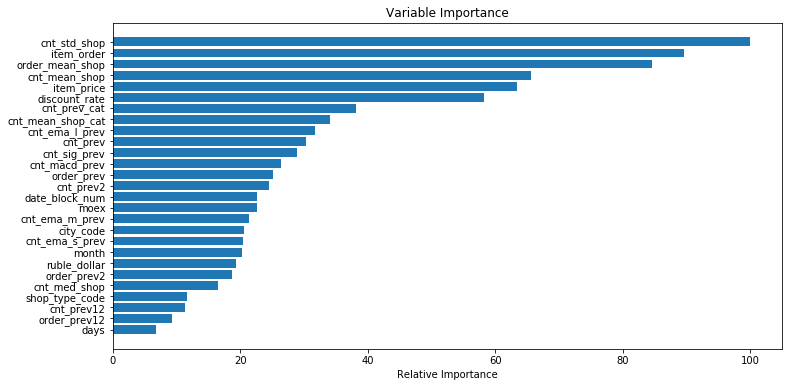

In [184]:
feature_importance = reg.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12,6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# Prediction for feature sales

### compare with last month / last year in the same month

It is collected in another try out python script, and due to time limitation(Modeling iteration needs too long to train the result, I will use the result in another python script to give business insights in terms of prediction.

In [139]:
# X_test.head()
# X_result = X_test.copy()
# X_result['sales'] = sub_preds
# grouped=X_result[['sales','city_code']].groupby(by='city_code').sum().reset_index()
# last_month = train_set[train_set['date_block_num']==33].copy()
# lastyear_Nov = train_set[train_set['date_block_num']==22].copy()
# last_month_city = last_month.groupby(by='city_code').sum().reset_index()[['city_code','item_cnt']]
# last_year_city = lastyear_Nov.groupby(by='city_code').sum().reset_index()[['city_code','item_cnt']]
# group_city = pd.merge(grouped, last_month_city, on=['city_code'], how='left')
# group_city = pd.merge(group_city, last_year_city , on=['city_code'], how='left')
# grouped.plot.bar(x = 'city_code',y = 'sales',figsize=(20,4))